# Numerical differentiation

To calculate the derivatives of functions for which a simple analytical derivative is known, the best approach is obvious: perform the derivation, and calculate the derivative directly with the derivation. For example, the derivative of $x^2$ is $2 x$, and if you know ahead of time that this is what you need, without resorting to the "numerical" methods we'll discuss below.

However, there are often situations in which either:
  1. The analytical derivative does not exist.
  2. The analytical derivative is difficult to derive and/or code up.
  3. You don't know ahead of time which function you need to differentiate.

If you find yourself in any of those 3 scenarios, numerical differentiation may be a reasonable solution. In current practice, it is especially important to the optimization of non-linear models: e.g., the estimation of statistical models such as Logit or Probit models, or the estimation/calibration of macroeconomic models.

Numerical differentiation is also central to the optimization algorithms used in the training of Machine Learning and Generative AI models.

## A quick introduction

Let's start with an oft-cited component/corollary of the **First Fundamental Theorem of Calculus:**

$$f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h} $$

**A rough corollary, which is useful numerically:**

$$\begin{align} f'(x) &\approx \frac{f(x+h) - f(x)}{h}, \\ \\
&\text{ for some $h$ that is ``small enough''}\end{align} $$

Let's try it out. First, in the next cell, we'll define three functions:
  1. `forward_numdiff`: our basic numerical differentiation function as .
  2. `demo_various_h_values`, which will make a graph for us to plot approximations for a series of increasingly small values of `h` against the true first derivative, which is supplied as an argument to the function.
  3. `side_by_side_numdiff_demos`, which will give us the ability to easily plot several demos for different functions side-by-side, with the inputs for each function supplied in a dictionary format. Works best for a maximum of 3 or 4 demos at a time.

In [1]:
%%% Find root directory and add it and all subfolders to Matlab path
%%%
%%% Because Jupyter Matlab kernel workspace is shared between all Jupyter instances the working directory may "drift" away from location of notebook
%%% This code will solve that problem, for notebooks that are in some folder under the root folder `econphd-codecamp`

current_dir_elements = strsplit(pwd,filesep);
root_dir = strjoin({current_dir_elements{1:find(strcmp(current_dir_elements,'econphd-codecamp'))}},filesep);
addpath(genpath(root_dir))

In [2]:
%%file forward_firstderiv.m
function fprime = forward_firstderiv(f,x,h)
    fprime = (f(x + h) - f(x))./h;
end


File forward_firstderiv.m created successfully.

In [68]:
%%file demo_various_h_values.m
function ax = demo_various_h_values(f,deriv_func,x,hstart,num_steps,numdiff_func,...
                                    keyword_args)
    arguments
        f;
        deriv_func;
        x;
        hstart;
        num_steps;
        numdiff_func;
        keyword_args.is_tiled=logical(0);
        %keyword_args.subplot_ydim=NaN;
        %keyword_args.subplot_xdim=NaN;
        %keyword_args.subplot_index=NaN;
        keyword_args.title='';
    end
    if ~keyword_args.is_tiled
        figure('Position',[0 0 300 240])
    end
    %if (isnan(keyword_args.subplot_ydim) || isnan(keyword_args.subplot_xdim) || isnan(keyword_args.subplot_index))
    %    figure()
    %    keyword_args.subplot_ydim = 1;
    %    keyword_args.subplot_xdim = 1;
    %    keyword_args.subplot_index = 1;
    %end
    %ax = subplot(keyword_args.subplot_ydim,keyword_args.subplot_xdim,keyword_args.subplot_index);
    hold on;
    plot(x,deriv_func(x),'k--','DisplayName','true derivative')
    for j = 1:num_steps
        plot(x,numdiff_func(f,x,hstart*(2^(-j+1))),...
             'b-.',...
             'DisplayName',['h = ' num2str(hstart*(2^(-j+1)),'%.2f') ],...
             'Color',[0 0 1 1.5^(-j+1)]...
             );
        %alpha(1.5^(-j+1));
    end
    hold off;
    title(keyword_args.title,'FontSize',8)
    legend('FontSize',6)
    a = get(gca,'XTickLabel');  
    set(gca,'XTickLabel',a,'fontsize',6)
    set(gca,'XTickLabelMode','auto')
    a = get(gca,'YTickLabel');  
    set(gca,'YTickLabel',a,'fontsize',6)
    set(gca,'YTickLabelMode','auto')
end
    

File demo_various_h_values.m created successfully.

In [75]:
%%file side_by_side_numdiff_demos.m
function side_by_side_numdiff_demos(struct_of_inputs,hstart,num_steps,numdiff_func,...
                                    default_figsize)
    arguments
        struct_of_inputs;
        hstart;
        num_steps;
        numdiff_func;
        default_figsize.x=0;
        default_figsize.y=0;
        default_figsize.width=300;
        default_figsize.height=240;
    end
    struct_fields = fields(struct_of_inputs);
    n_plots = length(struct_fields);
    fig_width = default_figsize.width*n_plots + 40*(n_plots-1);
    disp(fig_width)
    figure('Units', 'points',...
           'OuterPosition',[default_figsize.x default_figsize.y fig_width default_figsize.height]...
           )
    tiledlayout(1,num_steps,'TileSpacing','compact')  %('Position', [default_figsize.x default_figsize.y default_figsize.width*n_plots default_figsize.height]);
    for j = 1:n_plots
        nexttile
        cur_example = struct_of_inputs.(struct_fields{j});
        demo_various_h_values(cur_example.f,...
                              cur_example.deriv_of_f,...
                              cur_example.x,...
                              hstart,num_steps,...
                              numdiff_func,...
                              is_tiled=logical(1),...
                              title=cur_example.title...
                             );
                             %subplot_ydim=1,...
                             %subplot_xdim=num_steps,...
                             %subplot_index=j,...
    end
end
    


File side_by_side_numdiff_demos.m created successfully.

In this next cell, we construct one example, for $f(x) = x^2$. It's a little bit boring, but it illustrates the essential point: the smaller $h$ gets, the closer the approximation.

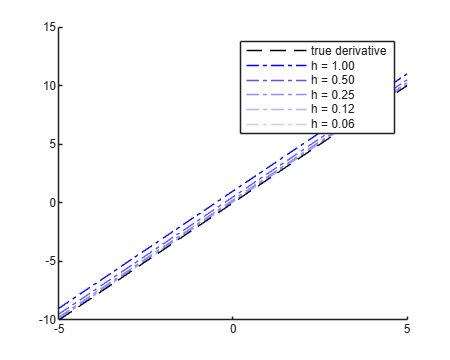

In [76]:
x = linspace(-5,5,1000);

f = @(x) x.^2;

true_f_prime = @(x) 2*x;

demo_various_h_values(f,true_f_prime,x,1,5,@forward_firstderiv);


In the cell below, we add two more examples: for a quartic polynomial, and for the natural logarithm. We can see that more complex functions may be more sensitive to the size of $h$, and that this sensitivity may be different for different values.

   980



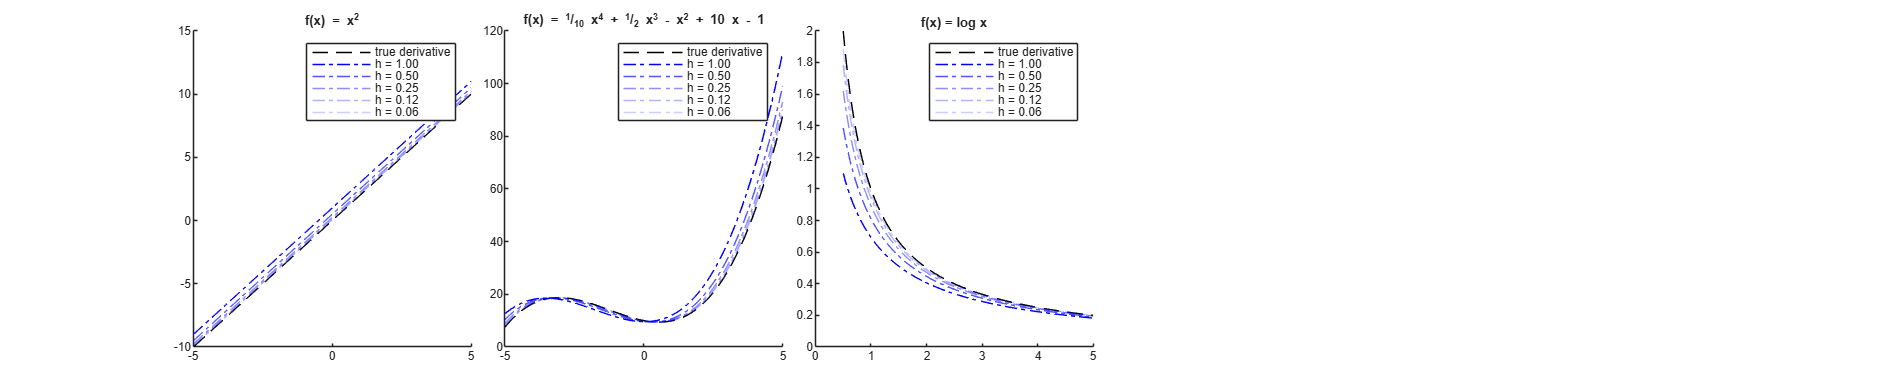

In [78]:
set_of_examples = struct(...
    'x_squared', struct(...
        'x',linspace(-5,5,1000),...
        'f',@(x) x.^2,...
        'deriv_of_f',@(x) 2*x,...
        'title','f(x) = x^2'...
    ),...
    'x_polynom_4thdeg', struct(...
        'x',linspace(-5,5,1000),...
        'f',@(x) .1*x.^4 + .5*x.^3 - x.^2 + 10*x - 1,...
        'deriv_of_f',@(x) .4*x.^3 + 1.5*x.^2 - 2*x + 10,...
        'title','f(x) = ^{1}/_{10} x^4 + ^{1}/_{2} x^3 - x^2 + 10 x - 1'...
    ),...
    'log_x', struct(...
        'x',linspace(0.5,5,1000),...
        'f',@(x) log(x),...
        'deriv_of_f',@(x) 1./x,...
        'title','f(x) = log x'...
    )...
);

side_by_side_numdiff_demos(set_of_examples,1,5,@forward_firstderiv)

## Going deeper: Numerical differentiation and Taylor expansion

We can gain more insight into what we're doing here by relating the finite difference formula to what we already know about Taylor expansions.

The Taylor expansion around $x$ for an arbitrary differentiable function $f(x+h)$ is given by:

$$\begin{align}f(x+h) &= f(x) + \frac{f'(x)}{1!}(x + h - x) + \frac{f''(x)}{2!}(x + h - x)^2 + \frac{f'''(x)}{3!}(x + h - x)^3 + \dots\\
&= f(x) + f'(x)h + \frac{f''(x)}{2!}h^2 + \frac{f'''(x)}{3!}h^3 + \dots
\end{align}$$

Rearranging, we get

$$ f'(x) = \frac{f(x+h) - f(x)}{h} + A^{+}(h), $$

where we've folded all the 2$^\text{nd}$- and higher-order stuff into $A^{+}(h)$:

$$A^{+}(h) = -\left(\frac{f''(x)}{2!}h  +\frac{f'''(x)}{3!}h^2 +\frac{f''''(x)}{4!}h^3 + \dots \right)$$

So, we can see that in addition to being strongly suggested by the First Fundamental Theorem of Calculus, the finite difference formula is also a kind of Taylor approximation. Its approximation error, therefore, will be proportional to the approximation error of the first-order Taylor approximation of $f(x)$.

Importantly, we can also observe the following direct implications of our derived expression for $A^{+}(h)$:
 1. It will be decreasing in $h$.
 2. Its limit as $h \to 0$ will be 0.

### Other flavors of finite difference

What we've been working with so far is called the **forward** finite difference. If we consider a Taylor expansion around $x$ for $f(x-h)$ instead of $f(x+h)$, we directly get the **backward** finite difference formula:

$$ f(x) = \frac{f(x) - f(x-h)}{h} + A^{-}(h),$$

where $A^{-}(h)$ is defined as
$$A^{-}(h) = -\left(-\frac{f''(x)}{2!}h  +\frac{f'''(x)}{3!}h^2 -\frac{f''''(x)}{4!}h^3 + \dots \right)$$

If we put $\frac{1}{2}$ weight on each of the forward and the backward differences, and add them together, we get the **centered** difference formula:

$$ f(x) = \frac{f(x+h) - f(x-h)}{2h} + A^{+/-}(h),$$
where $A^{+/-}(h) = \frac{1}{2}A^{+}(h) + \frac{1}{2}A^{-}(h)$ is given by 

$$A^{+/-}(h) = -\left(\frac{1}{2}\frac{f''(x)}{2!}h -\frac{f''(x)}{2!}h  +\frac{f'''(x)}{3!}h^2 + \frac{1}{2}\frac{f''''(x)}{4!}h^3  -\frac{1}{2}\frac{f''''(x)}{4!}h^3 + \dots \right) =-\left(\frac{f'''(x)}{3!}h^2 + \frac{f'''(x)}{5!}h^4 + \frac{f'''(x)}{7!}h^6\dots \right) $$

Note that by the derivation of the errors for the 3 methods we've just given, half of the Taylor terms, the ones for even orders of derivative, will exactly cancel each other out when we combine the forward and backward difference formulas. This means that for any given step size $h$, the centered difference formula will tend to produce a much smaller estimation error. And the centered approximation for any $f()$ for which 3$^{\text{rd}}$ and higher derivatives are zero (such as a quadratic polynomial) will be exact.

Also note that the error of all three methods approaches 0 as $h$ approaches 0.

An alternative and equivalent formulation of the centered difference formula which is also often seen is the following:

$$ f(x) \approx \frac{f\left(x+\frac{h}{2}\right) - f\left(x-\frac{h}{2}\right)}{h},$$

Let's have a look at each of these in action. First, the backward difference:

In [79]:
%%file backward_firstderiv.m
function fprime = backward_firstderiv(f,x,h)
    fprime = (-f(x - h) + f(x))./h;
end


File backward_firstderiv.m created successfully.

   980



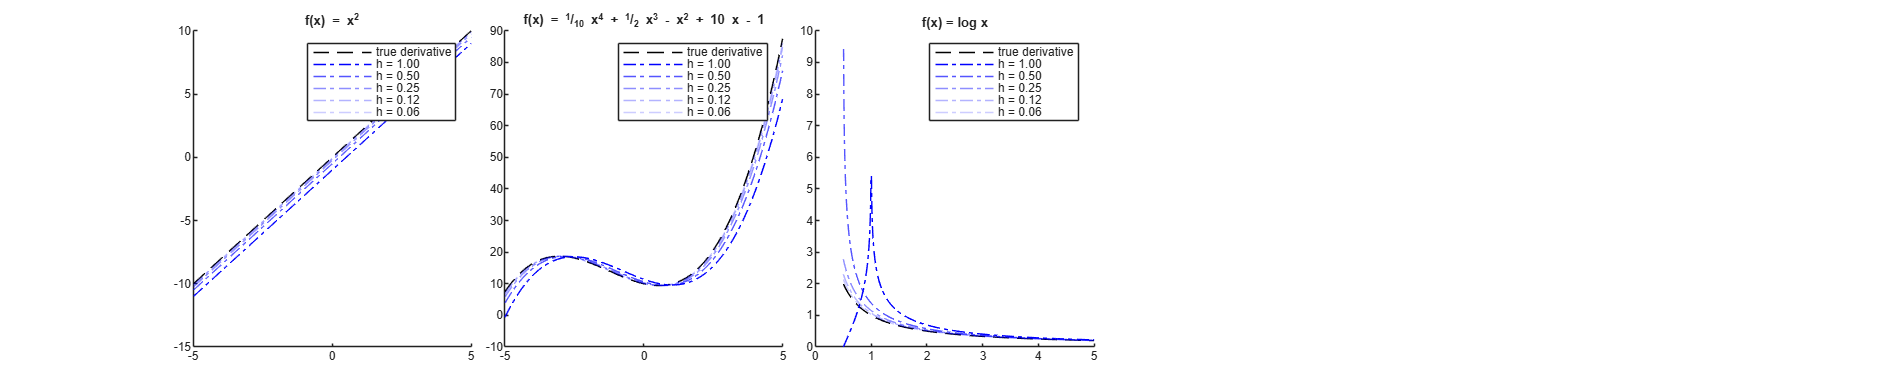

In [80]:
side_by_side_numdiff_demos(set_of_examples,1,5,@backward_firstderiv)



For many functions, especially polynomials, the errors of the backward difference look very similar to those of the forward difference, just reversed.

Now, let's look at the centered difference:

In [81]:
%%file centered_firstderiv.m
function fprime = centered_firstderiv(f,x,h)
    fprime = (f(x + h) - f(x-h))./(2*h);
end


File centered_firstderiv.m created successfully.

   980



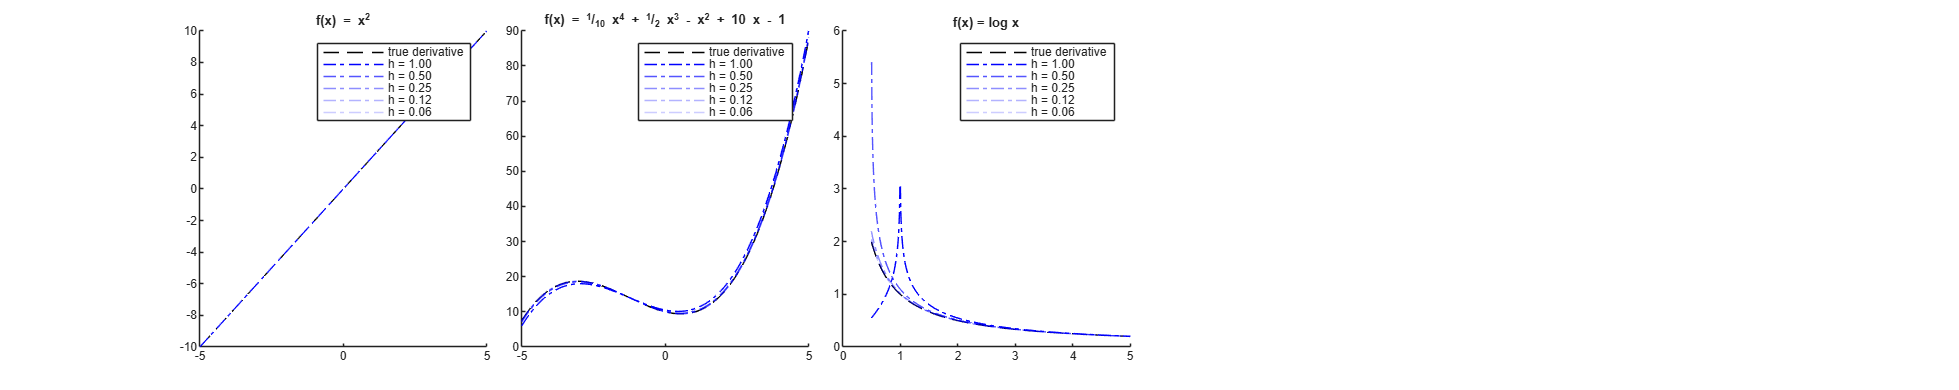

In [82]:
side_by_side_numdiff_demos(set_of_examples,1,5,@centered_firstderiv)

For the quadratic polynomial, the errors of the forward and backward differences perfectly cancel each other out so that the centered difference approximation is exact.

For higher-order polynomials and other functions, the errors are generally much smaller than with either of the other methods, though still not zero.

### Quick exercise for finite differences:

 - Set up a set of 3 functions different from the ones we've test so far, and try them out with one or more of the finite difference formulas.

### Second derivatives with finite differences

The quickest, easiest, and most flexible way to compute a second or higher-order derivative is simply to stack first order approximations on top of each other.

There are more precise formulas which you can find in textbooks and on the internet, which are based on further careful derivations from the Taylor expansion. In this quick lesson, we will not cover any of those.

We will derive a simplified second derivative formula for the forward difference, and show the result in the cell below:

 $$\begin{align}f'(x) &= \frac{f(x+h) - f(x)}{h}\\
 \iff\\
 f''(x) &= \frac{f'(x+h) - f'(x)}{h}\\
 &= \frac{1}{h} \left [\frac{f(x + h + h) - f(x+h)}{h} - \frac{f(x+h) - f(x)}{h}  \right ]\\
 &= \frac{f(x + 2h) - 2 f(x+h) + f(x))}{h^2}
 \end{align}$$

In [84]:
%%file forward_secondderiv.m
function fprime = forward_secondderiv(f,x,h)
    fprime = (f(x + 2*h) + f(x) - 2*f(x+h))./(h^2);
end


File forward_secondderiv.m created successfully.

   980



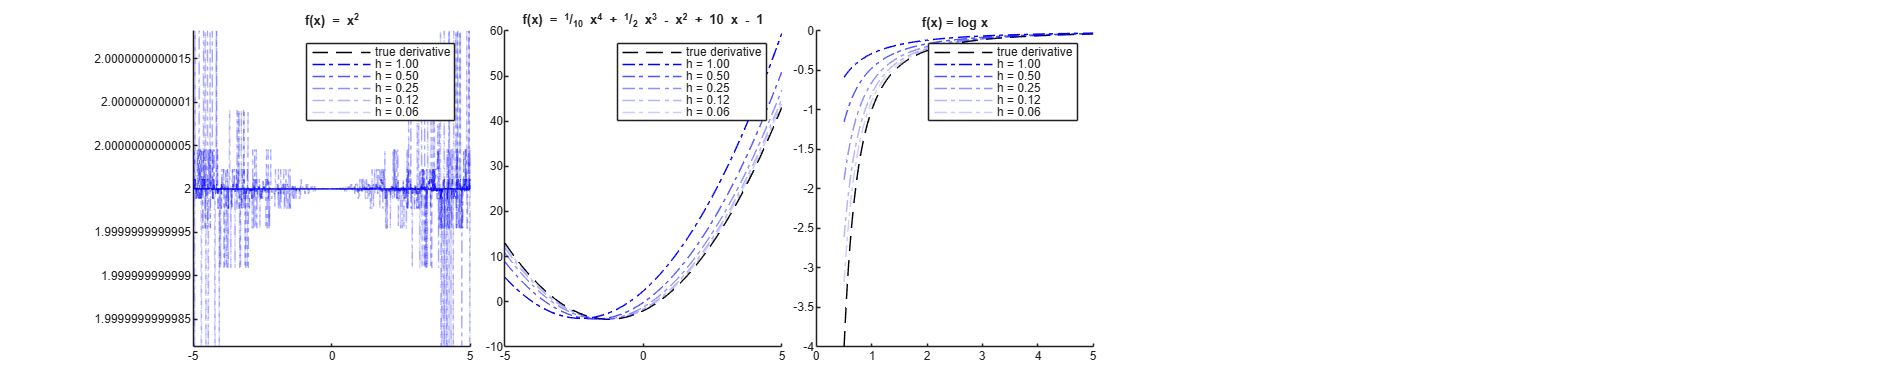

In [88]:
set_of_examples = struct(...
    'x_squared', struct(...
        'x',linspace(-5,5,1000),...
        'f',@(x) x.^2,...
        'deriv_of_f',@(x) 2*ones(length(x),1),...
        'title','f(x) = x^2'...
    ),...
    'x_polynom_4thdeg', struct(...
        'x',linspace(-5,5,1000),...
        'f',@(x) .1*x.^4 + .5*x.^3 - x.^2 + 10*x - 1,...
        'deriv_of_f',@(x) 1.2*x.^2 + 3*x - 2,...
        'title','f(x) = ^{1}/_{10} x^4 + ^{1}/_{2} x^3 - x^2 + 10 x - 1'...
    ),...
    'log_x', struct(...
        'x',linspace(0.5,5,1000),...
        'f',@(x) log(x),...
        'deriv_of_f',@(x) -1./(x.^2),...
        'title','f(x) = log x'...
    )...
);


side_by_side_numdiff_demos(set_of_examples,1,5,@forward_secondderiv)



### Quick exercise for second derivatives

 - Write a function that computes the second derivative by feeding the first derivative into itself. Check that it yields a similar result to the function above, defined based on the analytical formula. Are the two results exactly the same?